# COMP-551 Assignment 1: Linear Regression on Bike Sharing Data

**Group 11**

This notebook implements linear regression from scratch and applies it to the UCI Bike Sharing dataset to predict daily bike rental counts.

## Environment Setup

In [103]:
#install dependencies
ip install -r requirements.txt

SyntaxError: invalid syntax (557793202.py, line 2)

In [ ]:
# For Google Colab - uncomment these lines:
# from google.colab import drive
# drive.mount("/content/drive")
# PROJECT_PATH = "/content/drive/MyDrive/comp551-Ass1"
# %cd $PROJECT_PATH

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Import our custom modules
from data_parser import process_csv, ArrayScaler, OutlierHandler
from linear_regression import LinearRegression
from feature_engineering import add_nonlinear_features

print("Environment ready!")
print("Current directory:", os.getcwd())




Environment ready!
Current directory: /Users/macbook/Desktop/Projects/comp551-Ass1


# Task 1: Data Acquisition, Preprocessing, and Exploration

## 1.1 Loading the Data

In [ ]:
# Load raw dataset
raw_df = pd.read_csv("data/day.csv")

print("Dataset Structure:")
print(f"Number of samples: {raw_df.shape[0]}")
print(f"Number of features: {raw_df.shape[1]}")
print(f"\nFeature names: {list(raw_df.columns)}")
print(f"\nData types:\n{raw_df.dtypes}")

# Display first few rows
print("\nFirst 5 rows:")
raw_df.head()

Dataset Structure:
Number of samples: 731
Number of features: 16

Feature names: ['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

Data types:
instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

First 5 rows:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## 1.2 Data Cleaning and Preprocessing

### Missing Values Check

In [ ]:
# Check for missing values
missing_counts = raw_df.isnull().sum()
print(f"Total missing values: {missing_counts.sum()}")
print(f"\nMissing values per column:\n{missing_counts}")

# Check for any non-standard missing value indicators
print(f"\nDataset info:")
raw_df.info()

Total missing values: 0

Missing values per column:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-n

**Finding:** The dataset contains no missing values, which is excellent for model training.

### Feature Selection and Data Leakage Prevention

In [ ]:
# Features we drop and why:
dropped_features = {
    "instant": "Row identifier - no predictive value",
    "dteday": "Date string - used only for temporal ordering",
    "casual": "Data leakage - component of target variable (cnt = casual + registered)",
    "registered": "Data leakage - component of target variable",
    "atemp": "High collinearity with 'temp' (r > 0.99)",
    "workingday": "Redundant - can be derived from 'holiday' and 'weekday'"
}

print("Features dropped and justification:")
for feat, reason in dropped_features.items():
    print(f"  - {feat}: {reason}")

# Verify correlation between temp and atemp
print(f"\nCorrelation between temp and atemp: {raw_df['temp'].corr(raw_df['atemp']):.4f}")
print(f"Correlation between casual+registered and cnt: {(raw_df['casual'] + raw_df['registered']).corr(raw_df['cnt']):.4f}")

Features dropped and justification:
  - instant: Row identifier - no predictive value
  - dteday: Date string - used only for temporal ordering
  - casual: Data leakage - component of target variable (cnt = casual + registered)
  - registered: Data leakage - component of target variable
  - atemp: High collinearity with 'temp' (r > 0.99)
  - workingday: Redundant - can be derived from 'holiday' and 'weekday'

Correlation between temp and atemp: 0.9917
Correlation between casual+registered and cnt: 1.0000


### Categorical Feature Identification

In [ ]:
# Identify categorical vs continuous features
categorical_features = {
    "season": "4 categories (winter, spring, summer, fall) - nominal",
    "yr": "2 categories (2011, 2012) - ordinal",
    "mnth": "12 categories (Jan-Dec) - cyclic ordinal",
    "holiday": "2 categories (yes/no) - binary",
    "weekday": "7 categories (Sun-Sat) - cyclic nominal",
    "weathersit": "4 categories (clear to heavy rain) - ordinal"
}

continuous_features = {
    "temp": "Normalized temperature in Celsius",
    "hum": "Normalized humidity",
    "windspeed": "Normalized wind speed"
}

print("Categorical Features:")
for feat, desc in categorical_features.items():
    unique_vals = raw_df[feat].nunique()
    print(f"  • {feat} ({unique_vals} unique values): {desc}")

print("\nContinuous Features:")
for feat, desc in continuous_features.items():
    print(f"  • {feat}: {desc}")
    print(f"    Range: [{raw_df[feat].min():.4f}, {raw_df[feat].max():.4f}]")

Categorical Features:
  • season (4 unique values): 4 categories (winter, spring, summer, fall) - nominal
  • yr (2 unique values): 2 categories (2011, 2012) - ordinal
  • mnth (12 unique values): 12 categories (Jan-Dec) - cyclic ordinal
  • holiday (2 unique values): 2 categories (yes/no) - binary
  • weekday (7 unique values): 7 categories (Sun-Sat) - cyclic nominal
  • weathersit (3 unique values): 4 categories (clear to heavy rain) - ordinal

Continuous Features:
  • temp: Normalized temperature in Celsius
    Range: [0.0591, 0.8617]
  • hum: Normalized humidity
    Range: [0.0000, 0.9725]
  • windspeed: Normalized wind speed
    Range: [0.0224, 0.5075]


## 1.3 Data Visualization and Exploratory Analysis

### Target Variable Distribution

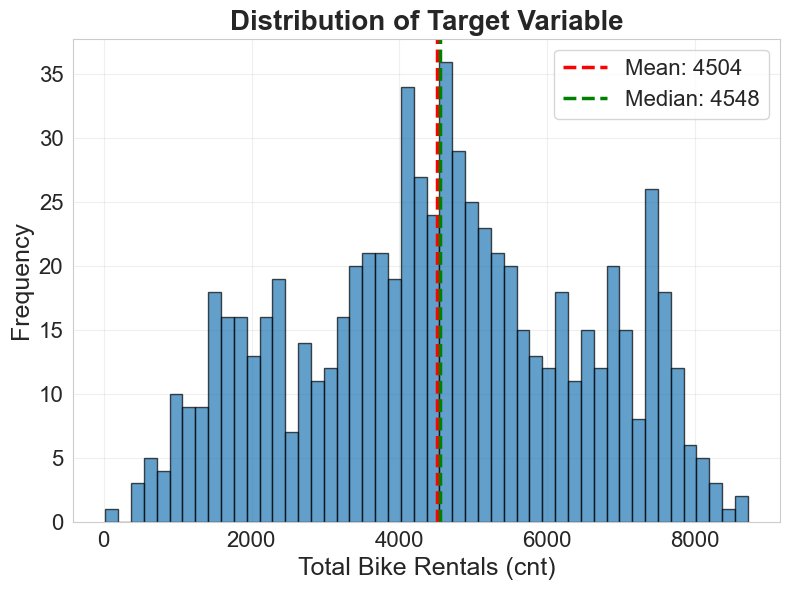

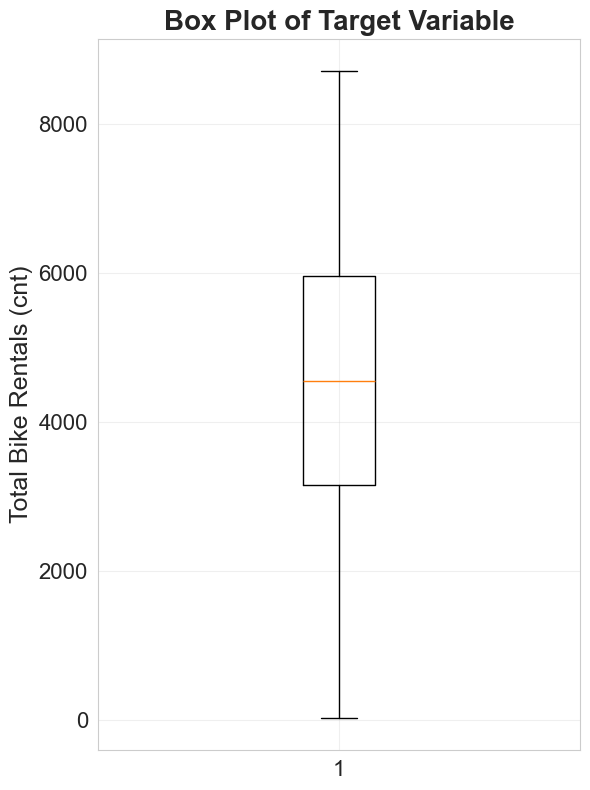

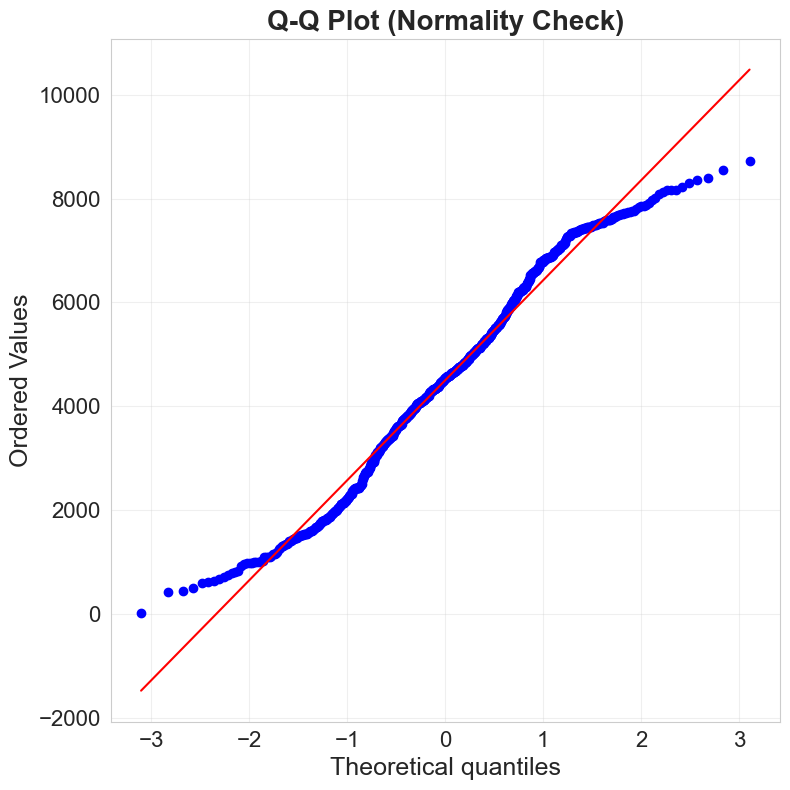

Target Variable Statistics:
count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64

Skewness: -0.0474
Kurtosis: -0.8119


In [ ]:

# Figure 1a: Histogram
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(raw_df['cnt'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(raw_df['cnt'].mean(), color='red', linestyle='--', linewidth=2.5, label=f"Mean: {raw_df['cnt'].mean():.0f}")
ax.axvline(raw_df['cnt'].median(), color='green', linestyle='--', linewidth=2.5, label=f"Median: {raw_df['cnt'].median():.0f}")
ax.set_xlabel('Total Bike Rentals (cnt)', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Distribution of Target Variable', fontsize=20, fontweight='bold')
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('target_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 1b: Box Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
ax.boxplot(raw_df['cnt'], vert=True)
ax.set_ylabel('Total Bike Rentals (cnt)', fontsize=18)
ax.set_title('Box Plot of Target Variable', fontsize=20, fontweight='bold')
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('target_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 1c: Q-Q Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
stats.probplot(raw_df['cnt'], dist="norm", plot=ax)
ax.set_title('Q-Q Plot (Normality Check)', fontsize=20, fontweight='bold')
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('target_qqplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary
print("Target Variable Statistics:")
print(raw_df['cnt'].describe())
print(f"\nSkewness: {raw_df['cnt'].skew():.4f}")
print(f"Kurtosis: {raw_df['cnt'].kurtosis():.4f}")

### Continuous Features Distribution

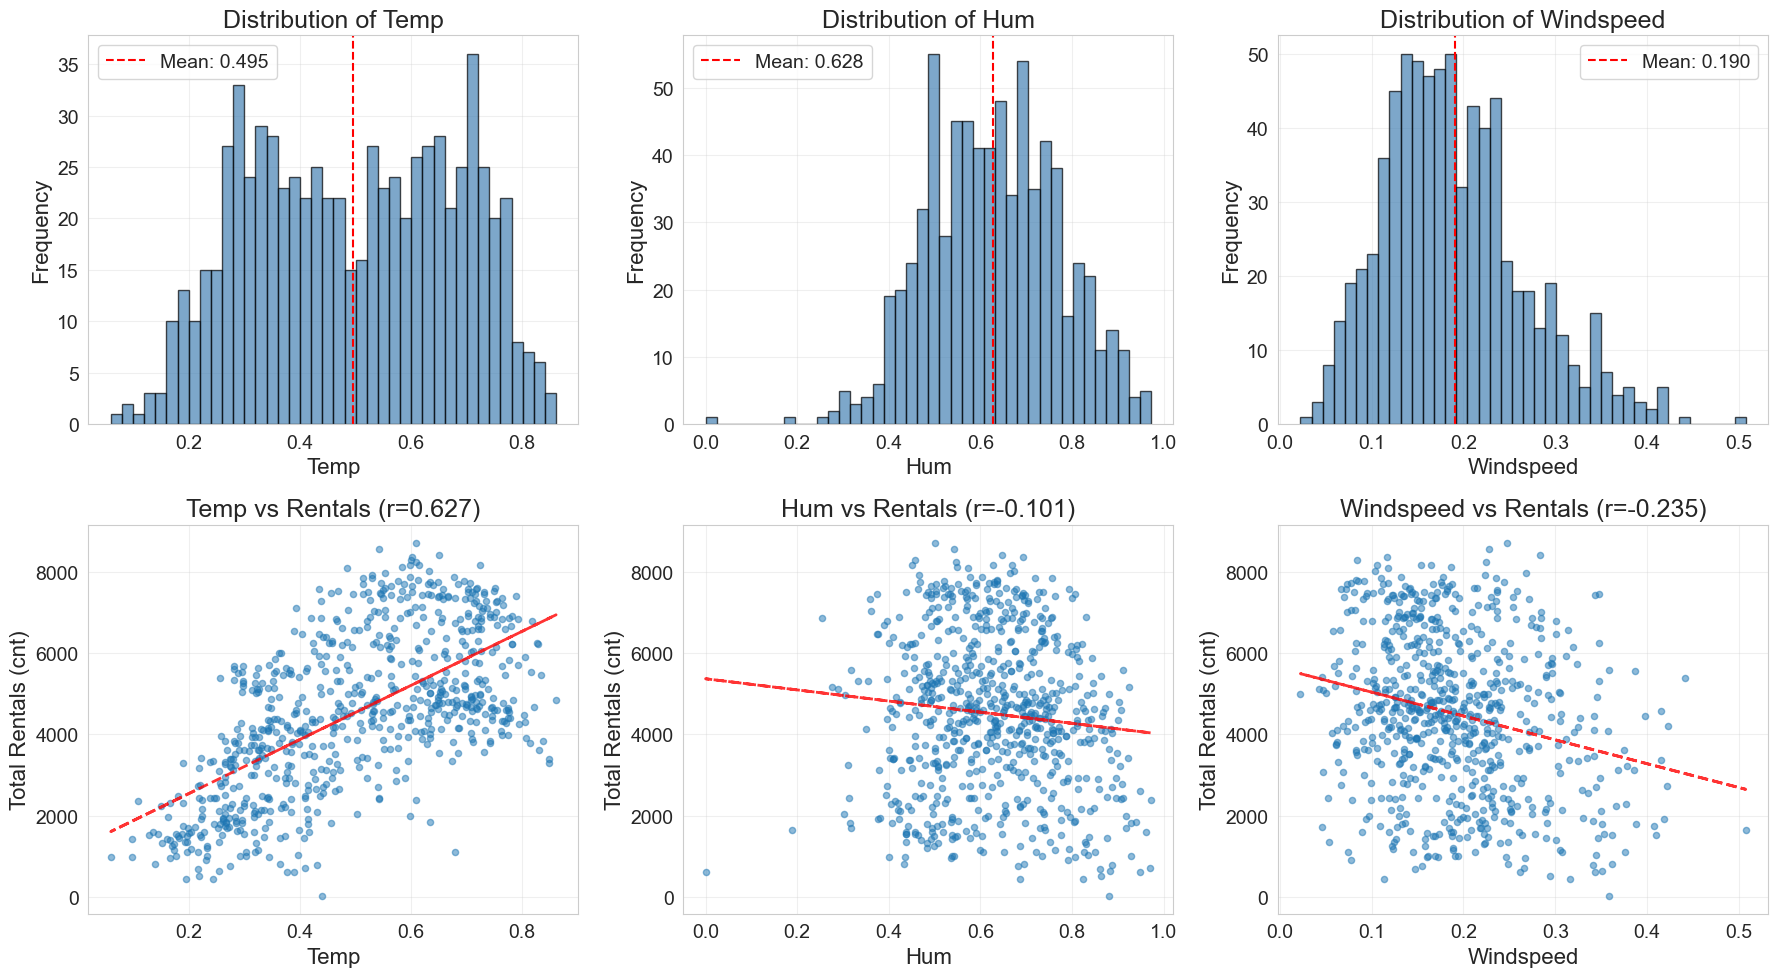

In [ ]:
# Visualize distributions of continuous features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
continuous_cols = ['temp', 'hum', 'windspeed']

for idx, col in enumerate(continuous_cols):
    # Histogram
    axes[0, idx].hist(raw_df[col], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, idx].axvline(raw_df[col].mean(), color='red', linestyle='--', 
                         label=f"Mean: {raw_df[col].mean():.3f}")
    axes[0, idx].set_xlabel(col.capitalize())
    axes[0, idx].set_ylabel('Frequency')
    axes[0, idx].set_title(f'Distribution of {col.capitalize()}')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Scatter plot against target
    axes[1, idx].scatter(raw_df[col], raw_df['cnt'], alpha=0.5, s=20)
    
    # Add trend line
    z = np.polyfit(raw_df[col], raw_df['cnt'], 1)
    p = np.poly1d(z)
    axes[1, idx].plot(raw_df[col], p(raw_df[col]), "r--", alpha=0.8, linewidth=2)
    
    corr = raw_df[col].corr(raw_df['cnt'])
    axes[1, idx].set_xlabel(col.capitalize())
    axes[1, idx].set_ylabel('Total Rentals (cnt)')
    axes[1, idx].set_title(f'{col.capitalize()} vs Rentals (r={corr:.3f})')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('continuous_features_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Categorical Features Analysis

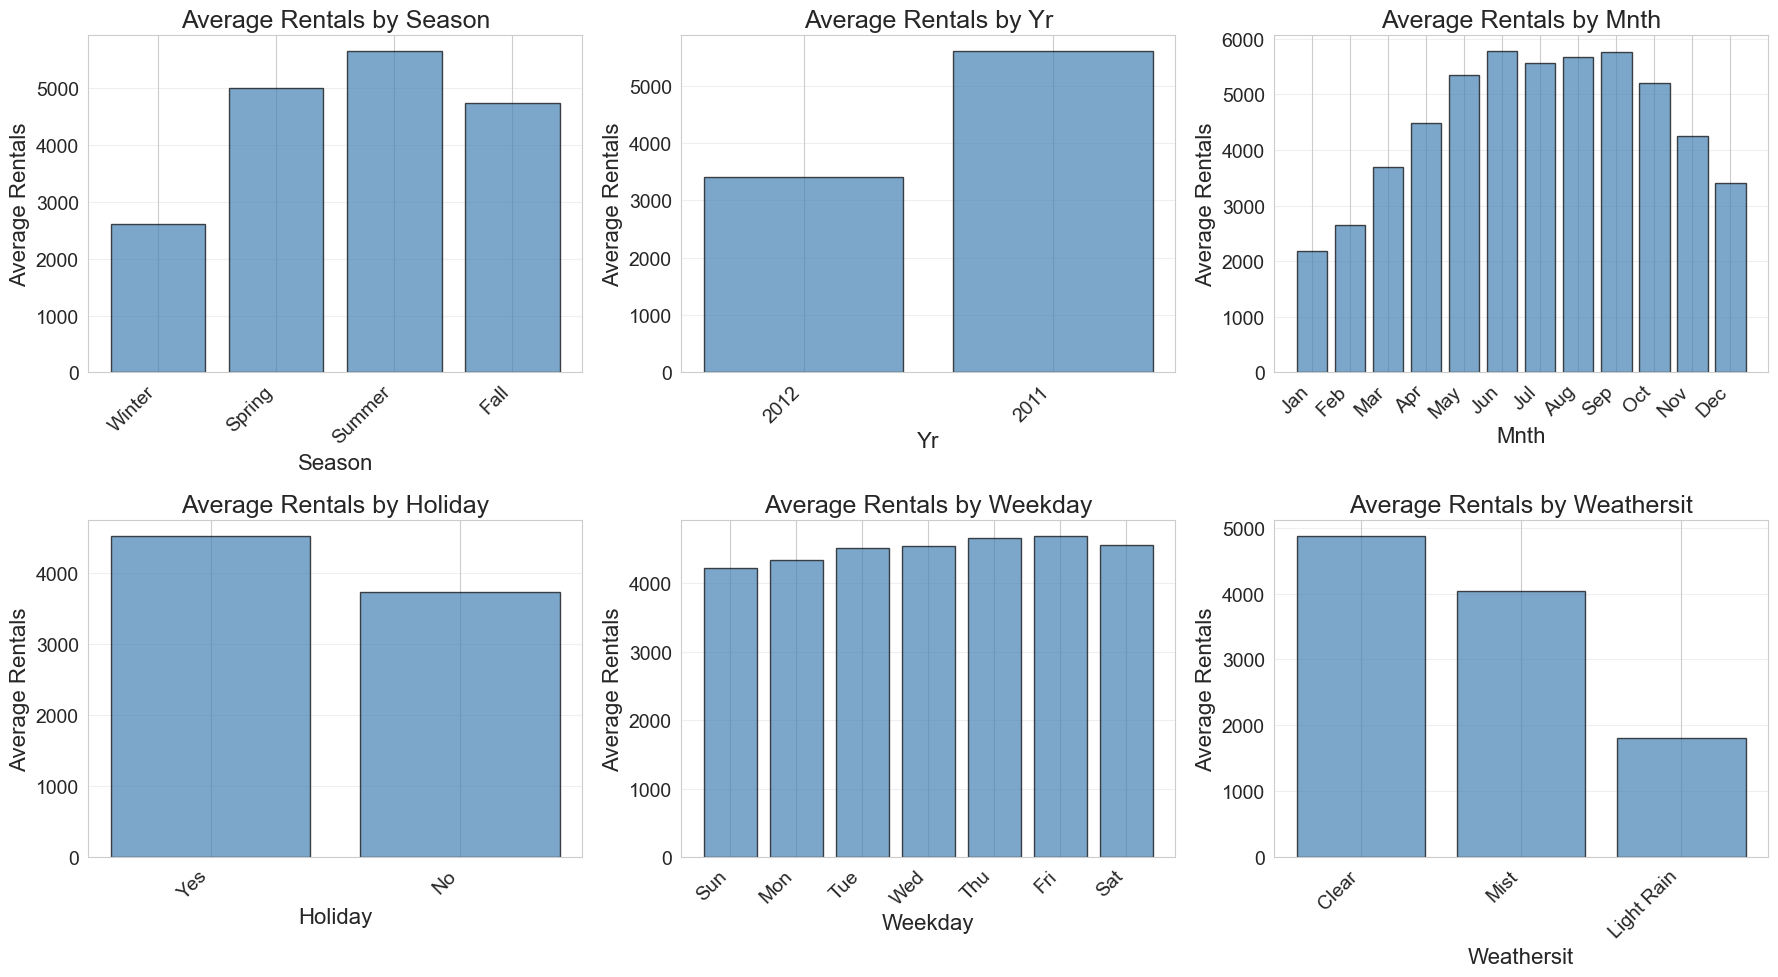

In [ ]:
# Analyze categorical features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

categorical_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'weathersit']
labels_map = {
    'season': ['Winter', 'Spring', 'Summer', 'Fall'],
    'yr': ['2011', '2012'],
    'mnth': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'holiday': ['No', 'Yes'],
    'weekday': ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    'weathersit': ['Clear', 'Mist', 'Light Rain', 'Heavy Rain']
}

for idx, col in enumerate(categorical_cols):
    grouped = raw_df.groupby(col)['cnt'].mean().sort_index()
    
    # Get labels
    if col in labels_map:
        x_labels = [labels_map[col][int(i)-1 if col != 'weekday' else int(i)] for i in grouped.index]
    else:
        x_labels = grouped.index
    
    axes[idx].bar(range(len(grouped)), grouped.values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_xticks(range(len(grouped)))
    axes[idx].set_xticklabels(x_labels, rotation=45, ha='right')
    axes[idx].set_xlabel(col.capitalize())
    axes[idx].set_ylabel('Average Rentals')
    axes[idx].set_title(f'Average Rentals by {col.capitalize()}')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('categorical_features_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation Analysis

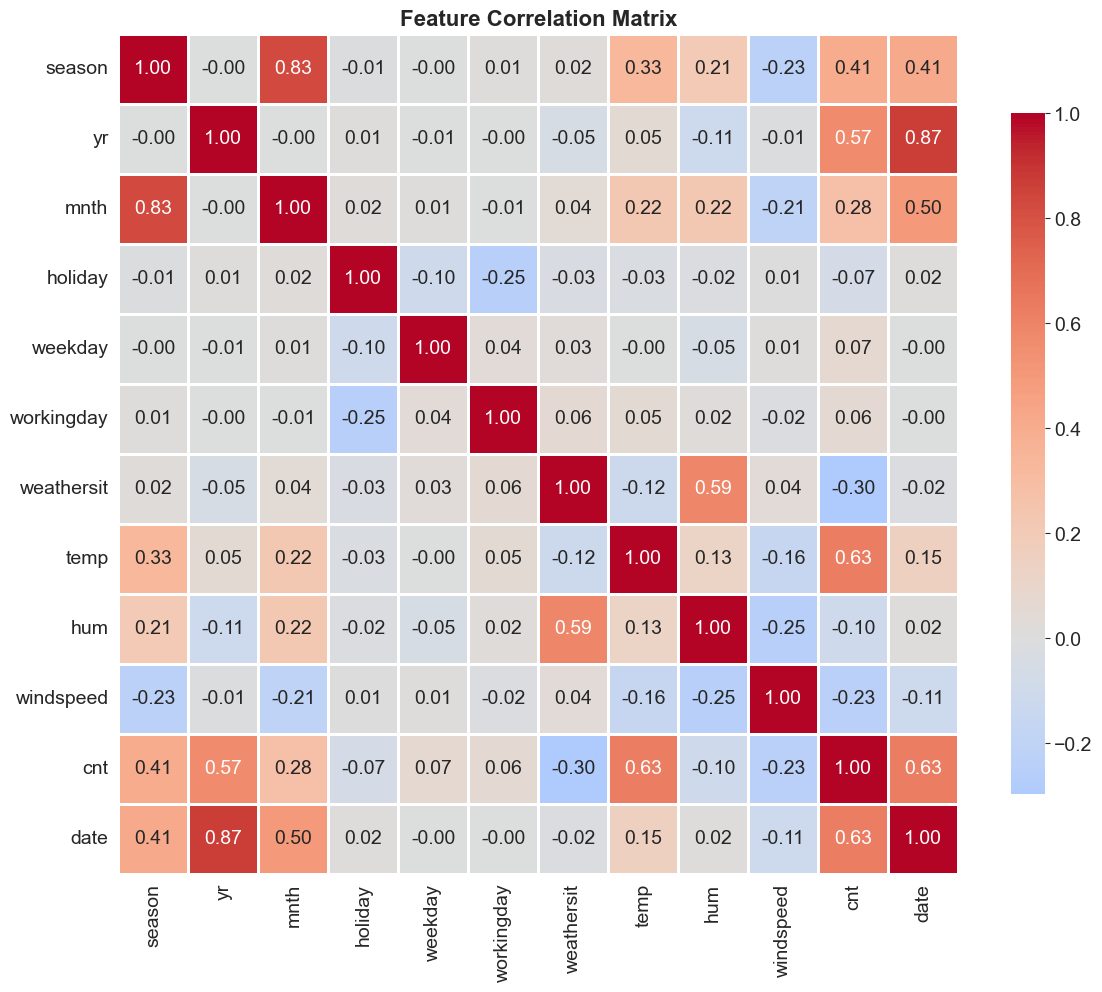


Correlations with target (cnt):
cnt           1.000000
date          0.628830
temp          0.627494
yr            0.566710
season        0.406100
mnth          0.279977
weekday       0.067443
workingday    0.061156
holiday      -0.068348
hum          -0.100659
windspeed    -0.234545
weathersit   -0.297391
Name: cnt, dtype: float64


In [ ]:
# Compute correlation matrix (excluding dropped features)
features_for_corr = [c for c in raw_df.columns if c not in ['instant', 'dteday', 'casual', 'registered', 'atemp']]
corr_matrix = raw_df[features_for_corr].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Display correlations with target
target_corr = corr_matrix['cnt'].sort_values(ascending=False)
print("\nCorrelations with target (cnt):")
print(target_corr)

### Temporal Patterns

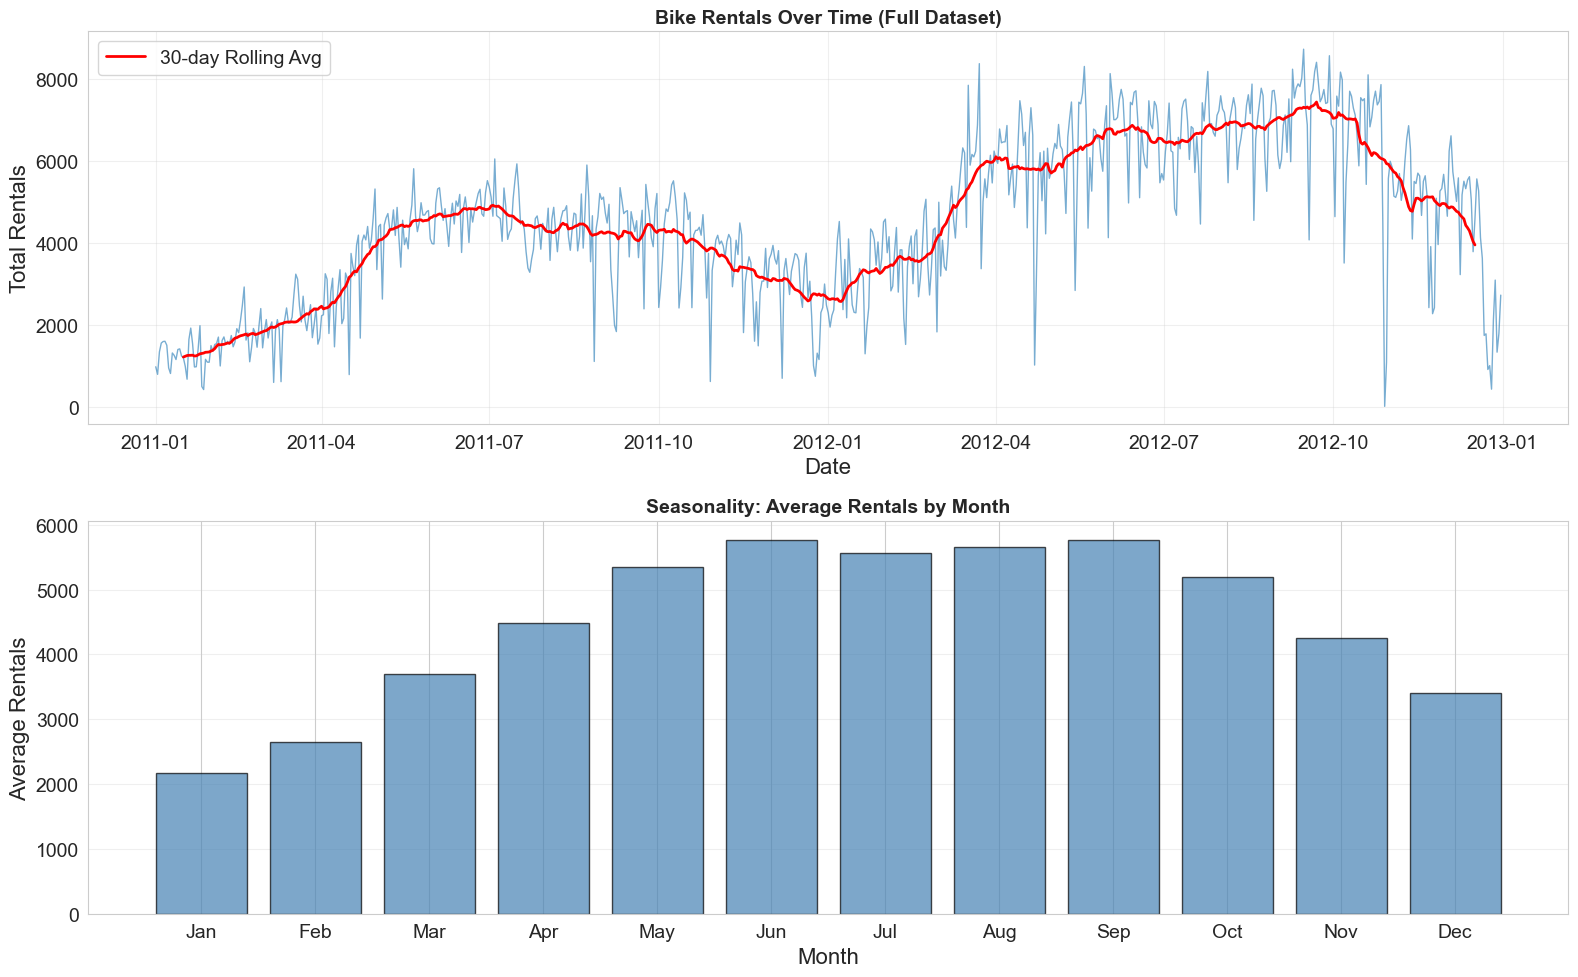

In [ ]:
# Time series visualization
raw_df['date'] = pd.to_datetime(raw_df['dteday'])

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full time series
axes[0].plot(raw_df['date'], raw_df['cnt'], linewidth=1, alpha=0.6)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Rentals')
axes[0].set_title('Bike Rentals Over Time (Full Dataset)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add 30-day rolling average
rolling_mean = raw_df['cnt'].rolling(window=30, center=True).mean()
axes[0].plot(raw_df['date'], rolling_mean, 'r-', linewidth=2, label='30-day Rolling Avg')
axes[0].legend()

# Monthly aggregation
monthly_avg = raw_df.groupby('mnth')['cnt'].mean().sort_index()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1].bar(range(1, 13), monthly_avg.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_labels)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Rentals')
axes[1].set_title('Seasonality: Average Rentals by Month', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

### Outlier Detection

In [ ]:
# Detect outliers in continuous features using IQR method
print("Outlier Analysis (IQR Method):")
print("=" * 35)

for col in continuous_cols:
    Q1 = raw_df[col].quantile(0.25)
    Q3 = raw_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = raw_df[(raw_df[col] < lower_bound) | (raw_df[col] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = 100 * n_outliers / len(raw_df)
    
    print(f"{col.capitalize():12} - Outliers: {n_outliers:3d} ({pct_outliers:5.2f}%)")
    print(f"{'':12}   Bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")
    
print("\nNote: Our preprocessing uses outlier clipping (not removal) to preserve data points.")

Outlier Analysis (IQR Method):
Temp         - Outliers:   0 ( 0.00%)
               Bounds: [-0.1404, 1.1329]
Hum          - Outliers:   2 ( 0.27%)
               Bounds: [0.2047, 1.0455]
Windspeed    - Outliers:  13 ( 1.78%)
               Bounds: [-0.0124, 0.3806]

Note: Our preprocessing uses outlier clipping (not removal) to preserve data points.


## Preprocessed Data Loading

Now we load the data using our preprocessing pipeline, which:
- Drops irrelevant/leaky features
- One-hot encodes categorical variables
- Clips outliers to prevent extreme values
- Standardizes continuous features (z-score normalization)
- Performs time-aware train/test split (80/20)

In [ ]:
# Load preprocessed data (baseline: no feature engineering)
X_train, X_test, y_train, y_test, feature_index = process_csv(
    "data/day.csv",
    train_frac=0.8,
    scaling_method="zscore",
    outlier_method="quantile",
    one_hot_encode=["season", "mnth", "weekday"]
)

print("Preprocessed Data Shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")
print(f"\nTotal features after preprocessing: {X_train.shape[1]}")
print(f"\nFeature index mapping:")
for name, idx in sorted(feature_index.items(), key=lambda x: x[1]):
    print(f"  {idx:2d}: {name}")

Preprocessed Data Shapes:
X_train: (584, 26)
X_test:  (147, 26)
y_train: (584,)
y_test:  (147,)

Total features after preprocessing: 26

Feature index mapping:
   0: yr
   1: holiday
   2: weathersit
   3: temp
   4: hum
   5: windspeed
   6: season_spring
   7: season_summer
   8: season_fall
   9: mnth_feb
  10: mnth_mar
  11: mnth_apr
  12: mnth_may
  13: mnth_jun
  14: mnth_jul
  15: mnth_aug
  16: mnth_sep
  17: mnth_oct
  18: mnth_nov
  19: mnth_dec
  20: weekday_mon
  21: weekday_tue
  22: weekday_wed
  23: weekday_thu
  24: weekday_fri
  25: weekday_sat


# Task 2: Linear Regression (Analytic Solution)

## 2.1 Model Implementation

Our `LinearRegression` class implements the closed-form solution:

$$\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

We use `np.linalg.lstsq()` instead of explicit matrix inversion for numerical stability. This function internally uses SVD decomposition.

In [ ]:
# Define MSE metric
def mse(y_true, y_pred):
    """Calculate Mean Squared Error"""
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(mse(y_true, y_pred))

def r2_score(y_true, y_pred):
    """Calculate R-squared score"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

## 2.2 Train Baseline Model

In [ ]:
# Train baseline model (no regularization)
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train, lam=0.0)

# Make predictions
y_train_pred_baseline = baseline_model.predict(X_train)
y_test_pred_baseline = baseline_model.predict(X_test)

# Calculate metrics
train_mse_baseline = mse(y_train, y_train_pred_baseline)
test_mse_baseline = mse(y_test, y_test_pred_baseline)
train_rmse_baseline = rmse(y_train, y_train_pred_baseline)
test_rmse_baseline = rmse(y_test, y_test_pred_baseline)
train_r2_baseline = r2_score(y_train, y_train_pred_baseline)
test_r2_baseline = r2_score(y_test, y_test_pred_baseline)


print("BASELINE MODEL PERFORMANCE (No Feature Engineering)")
print(f"Training Set:")
print(f"  MSE:  {train_mse_baseline:,.2f}")
print(f"  RMSE: {train_rmse_baseline:,.2f}")
print(f"  R²:   {train_r2_baseline:.4f}")
print(f"\nTest Set:")
print(f"  MSE:  {test_mse_baseline:,.2f}")
print(f"  RMSE: {test_rmse_baseline:,.2f}")
print(f"  R²:   {test_r2_baseline:.4f}")
print(f"\nGeneralization Gap (Test - Train RMSE): {test_rmse_baseline - train_rmse_baseline:,.2f}")


BASELINE MODEL PERFORMANCE (No Feature Engineering)
Training Set:
  MSE:  477,868.99
  RMSE: 691.28
  R²:   0.8504

Test Set:
  MSE:  1,238,116.41
  RMSE: 1,112.71
  R²:   0.6477

Generalization Gap (Test - Train RMSE): 421.43


## 2.3 Visualize Baseline Predictions

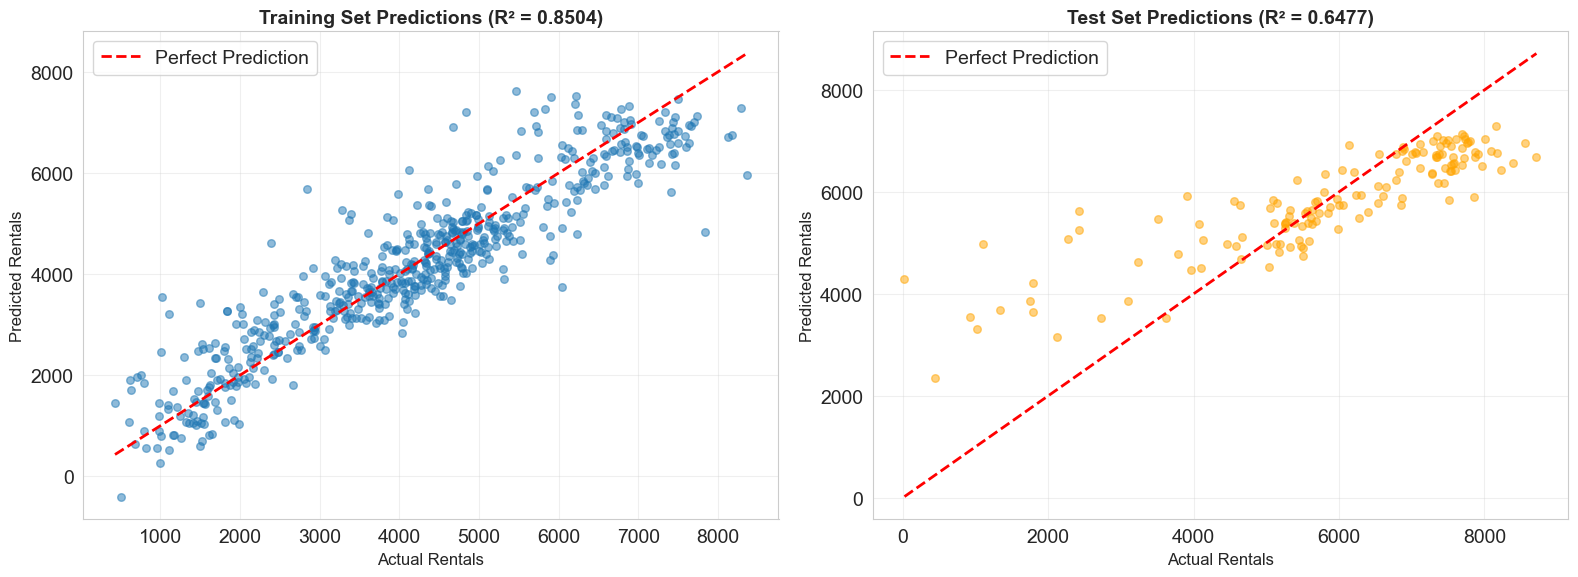

In [ ]:
# Create prediction plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set predictions
axes[0].scatter(y_train, y_train_pred_baseline, alpha=0.5, s=30)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rentals', fontsize=12)
axes[0].set_ylabel('Predicted Rentals', fontsize=12)
axes[0].set_title(f'Training Set Predictions (R² = {train_r2_baseline:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set predictions
axes[1].scatter(y_test, y_test_pred_baseline, alpha=0.5, s=30, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rentals', fontsize=12)
axes[1].set_ylabel('Predicted Rentals', fontsize=12)
axes[1].set_title(f'Test Set Predictions (R² = {test_r2_baseline:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.4 Residual Analysis

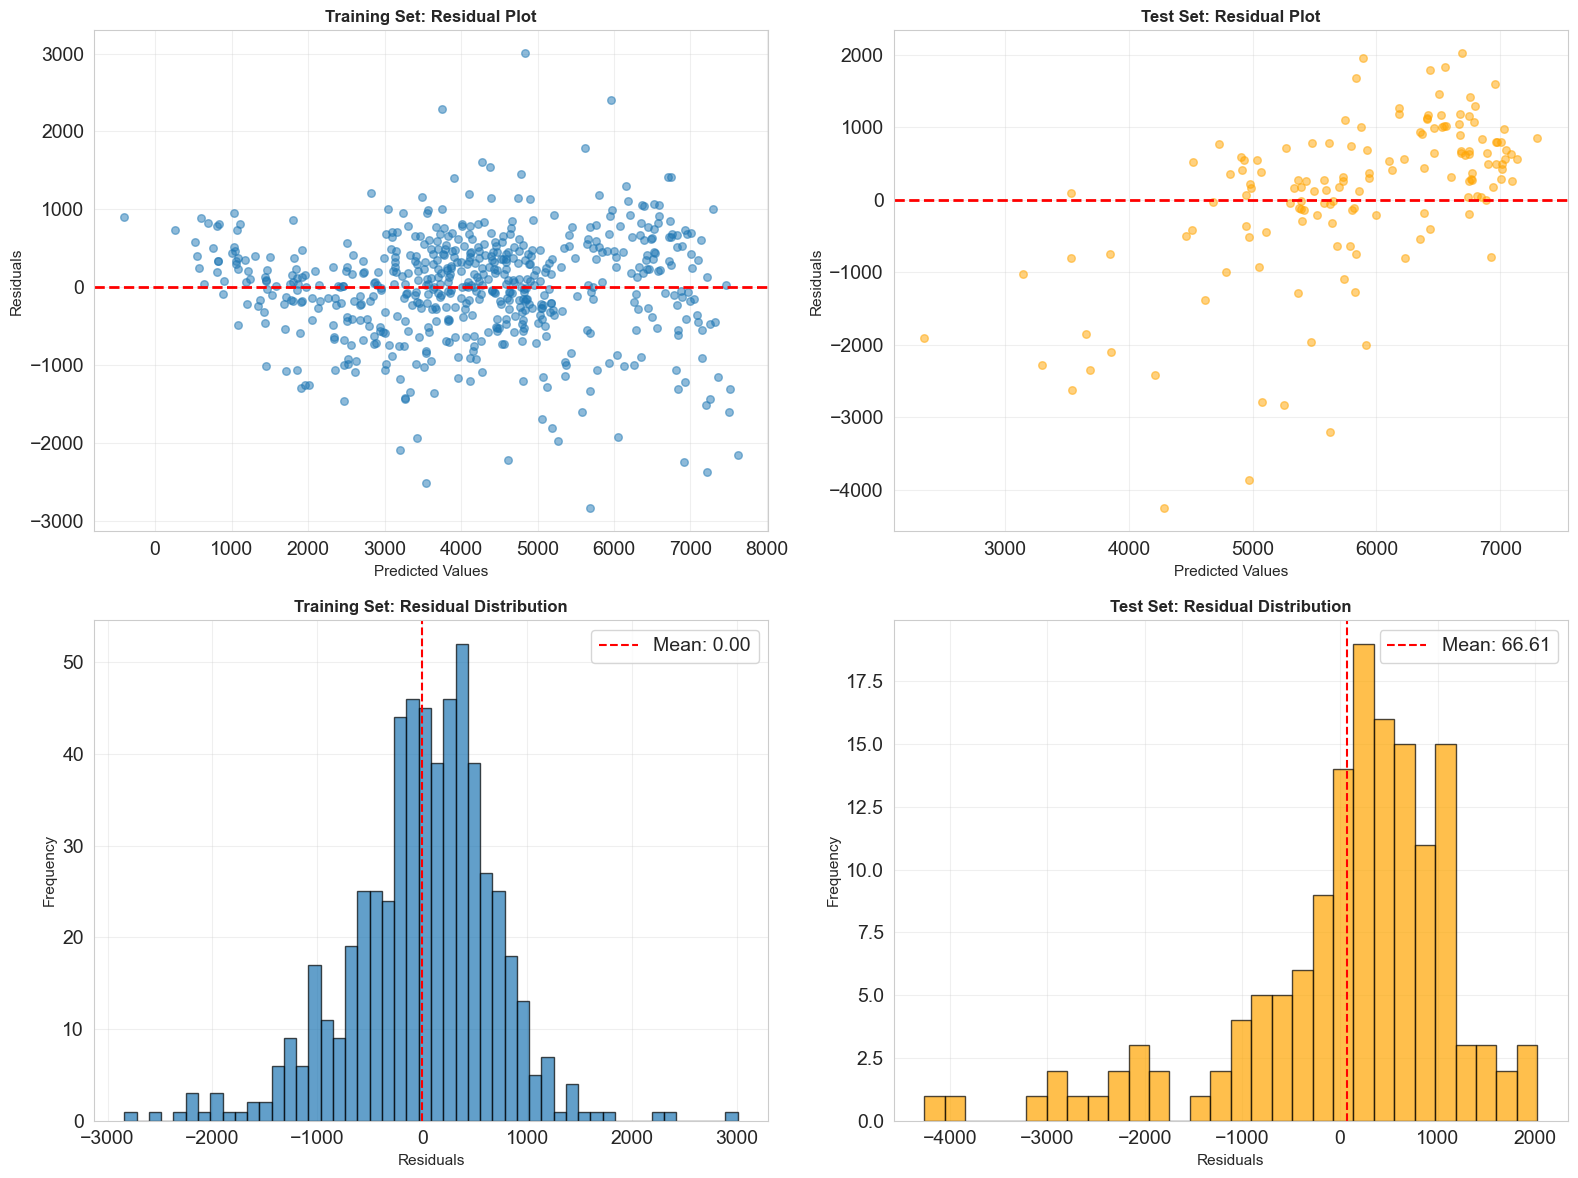

Residual Statistics:
Training - Mean: 0.00, Std: 691.28
Test     - Mean: 66.61, Std: 1110.71


In [ ]:
# Calculate residuals
train_residuals = y_train - y_train_pred_baseline
test_residuals = y_test - y_test_pred_baseline

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residual plot - Training
axes[0, 0].scatter(y_train_pred_baseline, train_residuals, alpha=0.5, s=30)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Training Set: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Residual plot - Test
axes[0, 1].scatter(y_test_pred_baseline, test_residuals, alpha=0.5, s=30, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Values', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('Test Set: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Residual distribution - Training
axes[1, 0].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(train_residuals.mean(), color='r', linestyle='--', 
                   label=f'Mean: {train_residuals.mean():.2f}')
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Training Set: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residual distribution - Test
axes[1, 1].hist(test_residuals, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].axvline(test_residuals.mean(), color='r', linestyle='--', 
                   label=f'Mean: {test_residuals.mean():.2f}')
axes[1, 1].set_xlabel('Residuals', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Test Set: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print("Residual Statistics:")
print(f"Training - Mean: {train_residuals.mean():.2f}, Std: {train_residuals.std():.2f}")
print(f"Test     - Mean: {test_residuals.mean():.2f}, Std: {test_residuals.std():.2f}")

# Task 3: Non-linear Feature Engineering

We explore three types of feature engineering:
1. **Polynomial features**: temp², hum², windspeed²
2. **Interaction features**: temp×hum, temp×windspeed, temp×weathersit
3. **Trigonometric encoding**: sin/cos of month (captures cyclical nature)

In [ ]:
# Load data without one-hot encoding month (needed for sin/cos transform)
X_train_fe, X_test_fe, y_train_fe, y_test_fe, fi_fe = process_csv(
    "data/day.csv",
    train_frac=0.8,
    scaling_method="zscore",
    outlier_method="quantile",
    one_hot_encode=["season", "weekday"]  # Don't one-hot encode month
)

# Add all three types of engineered features
X_train_fe, fi_fe = add_nonlinear_features(
    X_train_fe, fi_fe,
    polynomial=True,
    interaction=True,
    transform=True  # sin/cos of month
)

X_test_fe, _ = add_nonlinear_features(
    X_test_fe, fi_fe,
    polynomial=True,
    interaction=True,
    transform=True
)

print("Feature Engineering Applied:")
print(f"Original features: {X_train.shape[1]}")
print(f"Engineered features: {X_train_fe.shape[1]}")
print(f"New features added: {X_train_fe.shape[1] - X_train.shape[1]}")
print(f"\nNew feature names:")
new_features = ['temp_sq', 'hum_sq', 'windspeed_sq', 'temp_hum', 'temp_windspeed', 
                'temp_weathersit', 'month_sin', 'month_cos']
for feat in new_features:
    if feat in fi_fe:
        print(f"  • {feat} (index {fi_fe[feat]})")

Feature Engineering Applied:
Original features: 26
Engineered features: 24
New features added: -2

New feature names:
  • temp_sq (index 16)
  • hum_sq (index 17)
  • windspeed_sq (index 18)
  • temp_hum (index 19)
  • temp_windspeed (index 20)
  • temp_weathersit (index 21)
  • month_sin (index 22)
  • month_cos (index 23)


## 3.1 Train Feature-Engineered Model

In [ ]:
# Need to re-scale the engineered features
continuous_idx_fe = [fi_fe[name] for name in ['temp', 'hum', 'windspeed', 
                                                'temp_sq', 'hum_sq', 'windspeed_sq',
                                                'temp_hum', 'temp_windspeed', 'temp_weathersit']]

scaler_fe = ArrayScaler(method="zscore", idx=continuous_idx_fe)
scaler_fe.fit(X_train_fe)
X_train_fe = scaler_fe.transform(X_train_fe)
X_test_fe = scaler_fe.transform(X_test_fe)

# Train model with engineered features
model_fe = LinearRegression()
model_fe.fit(X_train_fe, y_train_fe, lam=0.0)

# Predictions
y_train_pred_fe = model_fe.predict(X_train_fe)
y_test_pred_fe = model_fe.predict(X_test_fe)

# Metrics
train_mse_fe = mse(y_train_fe, y_train_pred_fe)
test_mse_fe = mse(y_test_fe, y_test_pred_fe)
train_rmse_fe = rmse(y_train_fe, y_train_pred_fe)
test_rmse_fe = rmse(y_test_fe, y_test_pred_fe)
train_r2_fe = r2_score(y_train_fe, y_train_pred_fe)
test_r2_fe = r2_score(y_test_fe, y_test_pred_fe)

print("FEATURE-ENGINEERED MODEL PERFORMANCE")
print(f"Training Set:")
print(f"  MSE:  {train_mse_fe:,.2f}")
print(f"  RMSE: {train_rmse_fe:,.2f}")
print(f"  R²:   {train_r2_fe:.4f}")
print(f"\nTest Set:")
print(f"  MSE:  {test_mse_fe:,.2f}")
print(f"  RMSE: {test_rmse_fe:,.2f}")
print(f"  R²:   {test_r2_fe:.4f}")


FEATURE-ENGINEERED MODEL PERFORMANCE
Training Set:
  MSE:  402,863.58
  RMSE: 634.72
  R²:   0.8739

Test Set:
  MSE:  1,106,662.03
  RMSE: 1,051.98
  R²:   0.6851


## 3.2 Compare Baseline vs Feature-Engineered

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²'],
    'Baseline': [
        f"{train_mse_baseline:,.2f}",
        f"{test_mse_baseline:,.2f}",
        f"{train_rmse_baseline:,.2f}",
        f"{test_rmse_baseline:,.2f}",
        f"{train_r2_baseline:.4f}",
        f"{test_r2_baseline:.4f}"
    ],
    'Feature Engineered': [
        f"{train_mse_fe:,.2f}",
        f"{test_mse_fe:,.2f}",
        f"{train_rmse_fe:,.2f}",
        f"{test_rmse_fe:,.2f}",
        f"{train_r2_fe:.4f}",
        f"{test_r2_fe:.4f}"
    ],
    'Improvement': [
        f"{100*(train_mse_baseline - train_mse_fe)/train_mse_baseline:.2f}%",
        f"{100*(test_mse_baseline - test_mse_fe)/test_mse_baseline:.2f}%",
        f"{100*(train_rmse_baseline - train_rmse_fe)/train_rmse_baseline:.2f}%",
        f"{100*(test_rmse_baseline - test_rmse_fe)/test_rmse_baseline:.2f}%",
        f"{100*(train_r2_fe - train_r2_baseline)/train_r2_baseline:.2f}%",
        f"{100*(test_r2_fe - test_r2_baseline)/test_r2_baseline:.2f}%"
    ]
})

print("MODEL COMPARISON: Baseline vs Feature-Engineered")
print(comparison_df.to_string(index=False))


MODEL COMPARISON: Baseline vs Feature-Engineered
    Metric     Baseline Feature Engineered Improvement
 Train MSE   477,868.99         402,863.58      15.70%
  Test MSE 1,238,116.41       1,106,662.03      10.62%
Train RMSE       691.28             634.72       8.18%
 Test RMSE     1,112.71           1,051.98       5.46%
  Train R²       0.8504             0.8739       2.76%
   Test R²       0.6477             0.6851       5.78%


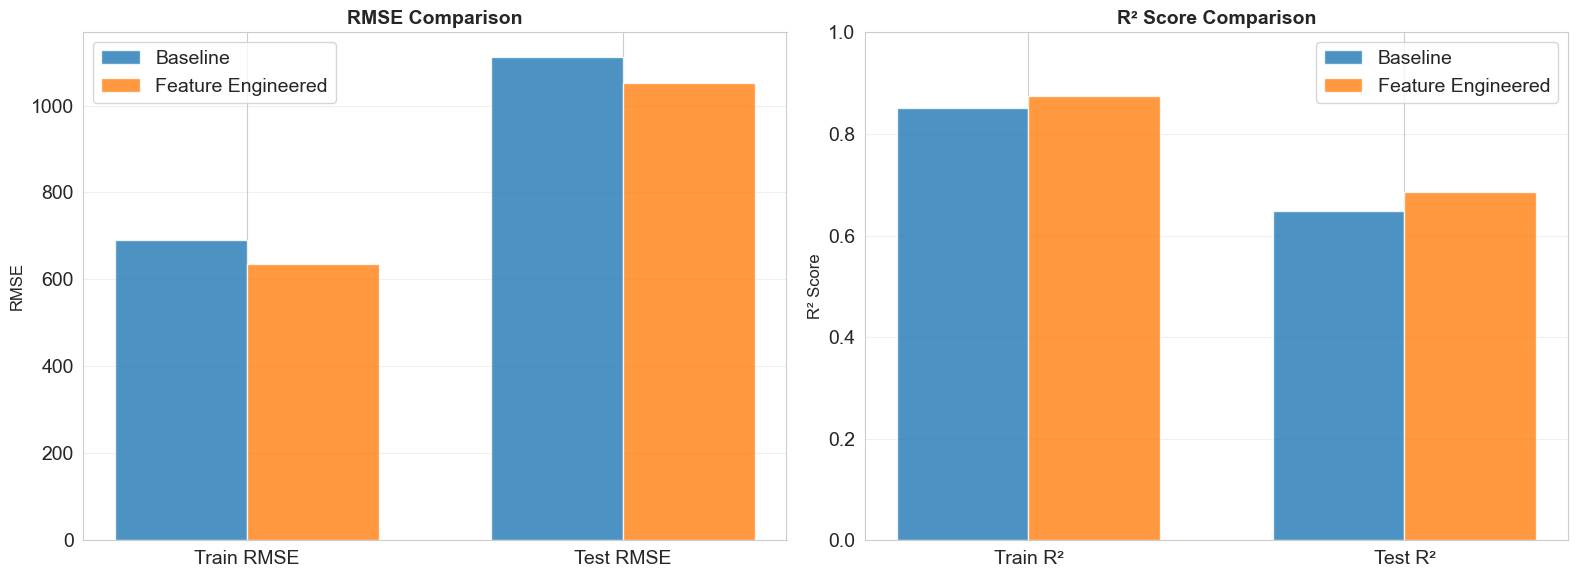

In [ ]:
# Visualization of improvement
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
metrics = ['Train RMSE', 'Test RMSE']
baseline_scores = [train_rmse_baseline, test_rmse_baseline]
fe_scores = [train_rmse_fe, test_rmse_fe]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.8)
axes[0].bar(x + width/2, fe_scores, width, label='Feature Engineered', alpha=0.8)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# R² comparison
r2_metrics = ['Train R²', 'Test R²']
baseline_r2 = [train_r2_baseline, test_r2_baseline]
fe_r2 = [train_r2_fe, test_r2_fe]

axes[1].bar(x - width/2, baseline_r2, width, label='Baseline', alpha=0.8)
axes[1].bar(x + width/2, fe_r2, width, label='Feature Engineered', alpha=0.8)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(r2_metrics)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Task 4: Analysis and Discussion

## Feature Importance Analysis

Top 15 Most Important Features (by absolute weight):
      Feature      Weight  Abs_Weight
           yr 2030.762431 2030.762431
     mnth_sep 1284.310891 1284.310891
     mnth_may 1164.152228 1164.152228
     mnth_jun 1061.742914 1061.742914
     mnth_oct 1058.826033 1058.826033
  season_fall  994.299623  994.299623
     mnth_aug  926.720191  926.720191
     mnth_apr  807.562464  807.562464
     mnth_mar  733.239125  733.239125
         temp  720.774129  720.774129
     mnth_jul  693.972907  693.972907
season_spring  687.967108  687.967108
     mnth_nov  671.919287  671.919287
     mnth_dec  631.486230  631.486230
   weathersit -539.636582  539.636582


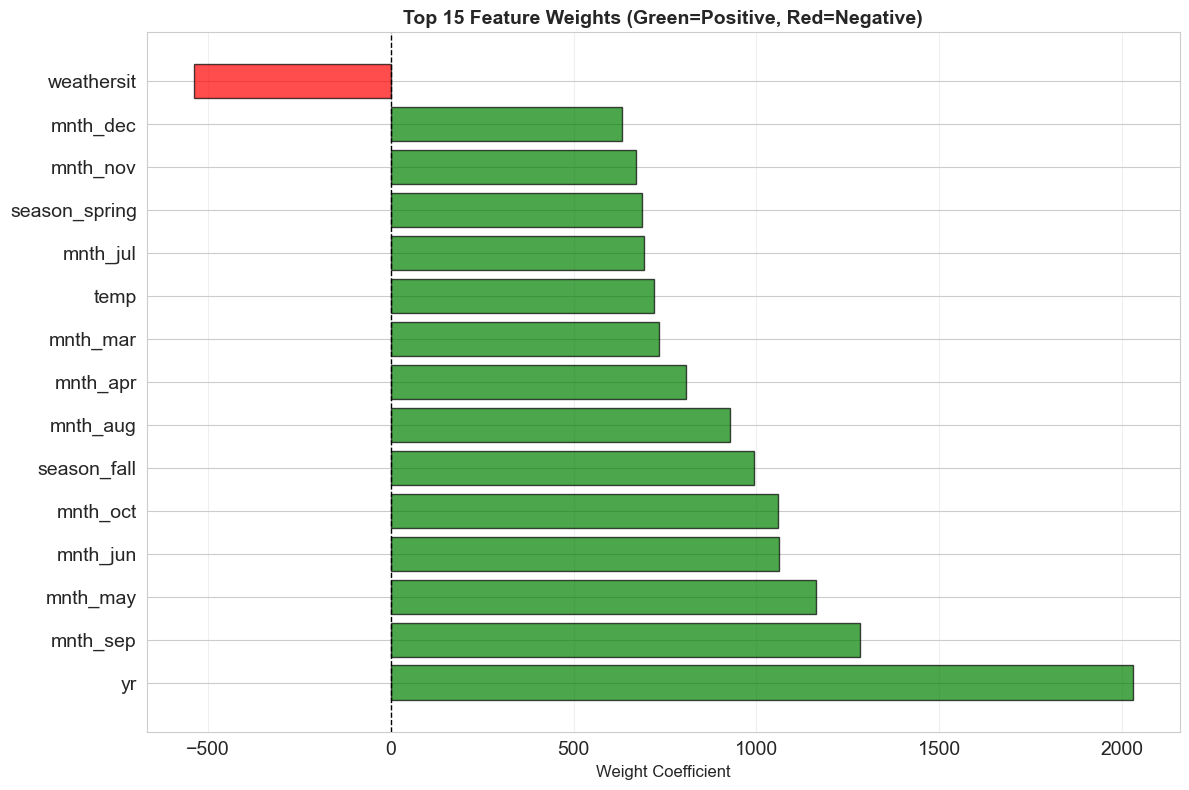

In [ ]:
# Extract and analyze feature weights from baseline model
feature_names = list(feature_index.keys())
weights_baseline = baseline_model.w[1:]  # Exclude bias term

# Create DataFrame for easier analysis
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights_baseline,
    'Abs_Weight': np.abs(weights_baseline)
}).sort_values('Abs_Weight', ascending=False)

print("Top 15 Most Important Features (by absolute weight):")
print(feature_importance.head(15).to_string(index=False))

# Visualize top features
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
colors = ['green' if w > 0 else 'red' for w in top_features['Weight']]
plt.barh(range(top_n), top_features['Weight'], color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Weight Coefficient', fontsize=12)
plt.title('Top 15 Feature Weights (Green=Positive, Red=Negative)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Effect of Regularization


Ridge Regression Results (varying λ):
 lambda  train_rmse   test_rmse  train_r2  test_r2
   0.00  691.280686 1112.706793  0.850415 0.647682
   0.01  691.281484 1112.407059  0.850415 0.647872
   0.10  691.347866 1110.120445  0.850386 0.649318
   1.00  693.473874 1105.237381  0.849465 0.652396
  10.00  713.732685 1188.931965  0.840541 0.597758
 100.00  878.133271 1716.749441  0.758621 0.161337


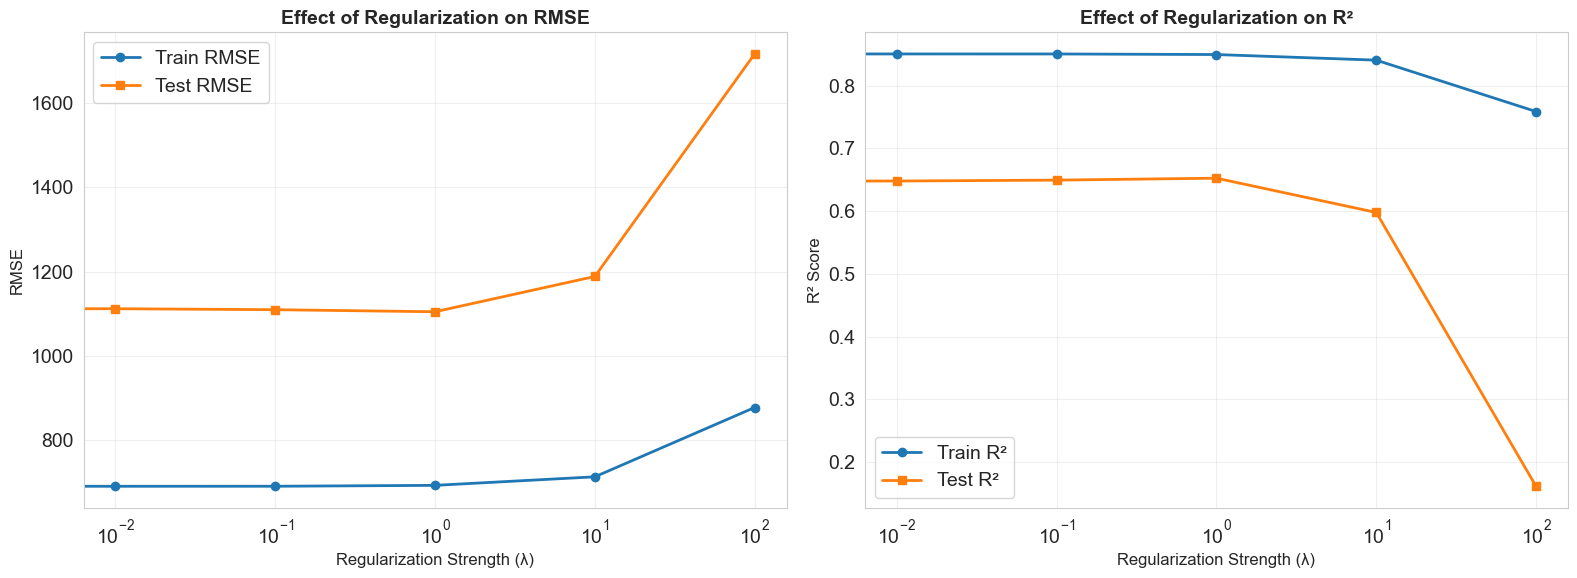

In [ ]:
# Test different regularization strengths
lambdas = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_results = []

for lam in lambdas:
    model_ridge = LinearRegression()
    model_ridge.fit(X_train, y_train, lam=lam)
    
    y_train_pred_ridge = model_ridge.predict(X_train)
    y_test_pred_ridge = model_ridge.predict(X_test)
    
    ridge_results.append({
        'lambda': lam,
        'train_rmse': rmse(y_train, y_train_pred_ridge),
        'test_rmse': rmse(y_test, y_test_pred_ridge),
        'train_r2': r2_score(y_train, y_train_pred_ridge),
        'test_r2': r2_score(y_test, y_test_pred_ridge)
    })

ridge_df = pd.DataFrame(ridge_results)
print("\nRidge Regression Results (varying λ):")
print(ridge_df.to_string(index=False))

# Plot regularization path
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(ridge_df['lambda'], ridge_df['train_rmse'], 'o-', label='Train RMSE', linewidth=2)
axes[0].plot(ridge_df['lambda'], ridge_df['test_rmse'], 's-', label='Test RMSE', linewidth=2)
axes[0].set_xlabel('Regularization Strength (λ)', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('Effect of Regularization on RMSE', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(ridge_df['lambda'], ridge_df['train_r2'], 'o-', label='Train R²', linewidth=2)
axes[1].plot(ridge_df['lambda'], ridge_df['test_r2'], 's-', label='Test R²', linewidth=2)
axes[1].set_xlabel('Regularization Strength (λ)', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Effect of Regularization on R²', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regularization_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Learning Curves

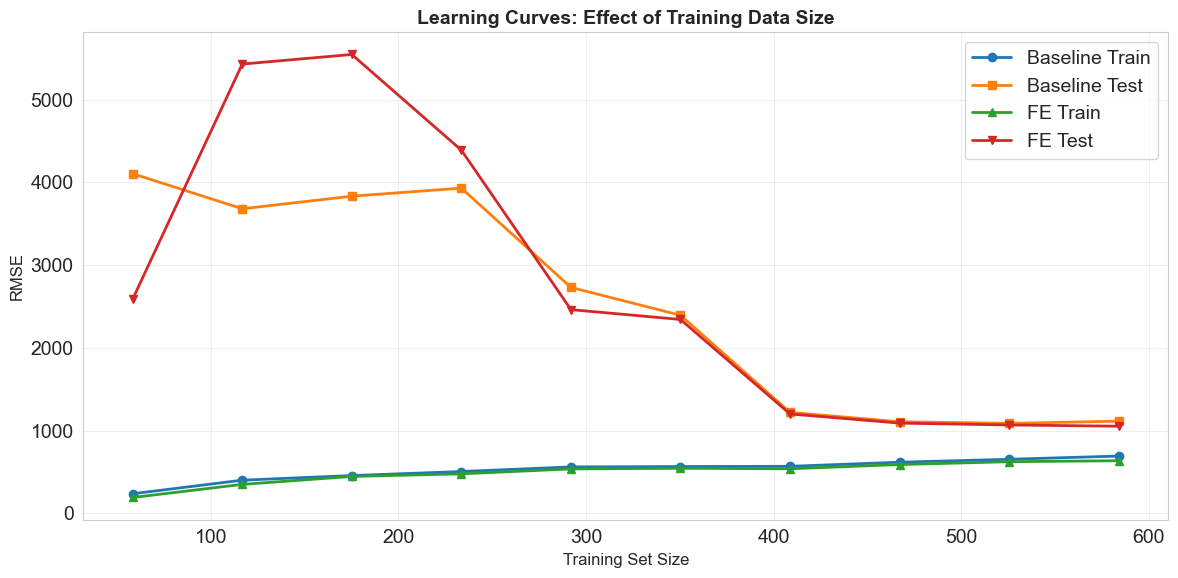

In [ ]:
# Generate learning curves to analyze bias-variance tradeoff
train_sizes = np.linspace(0.1, 1.0, 10)
n_train = len(X_train)

train_scores_baseline = []
test_scores_baseline = []
train_scores_fe = []
test_scores_fe = []

for train_size in train_sizes:
    n_samples = int(train_size * n_train)
    
    # Baseline model
    model_temp = LinearRegression()
    model_temp.fit(X_train[:n_samples], y_train[:n_samples])
    train_scores_baseline.append(rmse(y_train[:n_samples], model_temp.predict(X_train[:n_samples])))
    test_scores_baseline.append(rmse(y_test, model_temp.predict(X_test)))
    
    # Feature-engineered model
    model_temp_fe = LinearRegression()
    model_temp_fe.fit(X_train_fe[:n_samples], y_train_fe[:n_samples])
    train_scores_fe.append(rmse(y_train_fe[:n_samples], model_temp_fe.predict(X_train_fe[:n_samples])))
    test_scores_fe.append(rmse(y_test_fe, model_temp_fe.predict(X_test_fe)))

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_sizes * n_train, train_scores_baseline, 'o-', label='Baseline Train', linewidth=2)
plt.plot(train_sizes * n_train, test_scores_baseline, 's-', label='Baseline Test', linewidth=2)
plt.plot(train_sizes * n_train, train_scores_fe, '^-', label='FE Train', linewidth=2)
plt.plot(train_sizes * n_train, test_scores_fe, 'v-', label='FE Test', linewidth=2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Learning Curves: Effect of Training Data Size', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics and Final Report

In [ ]:
print("FINAL PROJECT SUMMARY")

print("\n1. DATASET CHARACTERISTICS:")
print(f"   - Total samples: {len(raw_df)}")
print(f"   - Training samples: {len(y_train)}")
print(f"   - Test samples: {len(y_test)}")
print(f"   - Original features: {len(feature_index)}")
print(f"   - Engineered features: {X_train_fe.shape[1]}")

print("\n2. PREPROCESSING DECISIONS:")
print("   - Missing values: None found - no imputation needed")
print("   - Dropped features: instant, dteday, casual, registered, atemp, workingday")
print("   - Categorical encoding: One-hot encoding for season, month, weekday")
print("   - Scaling method: Z-score standardization (mean=0, std=1)")
print("   - Outlier handling: Quantile clipping (1%-99%)")
print("   - Train/test split: 80/20 time-aware split")

print("\n3. BASELINE MODEL RESULTS:")
print(f"   - Training RMSE: {train_rmse_baseline:,.2f}")
print(f"   - Test RMSE: {test_rmse_baseline:,.2f}")
print(f"   - Training R²: {train_r2_baseline:.4f}")
print(f"   - Test R²: {test_r2_baseline:.4f}")

print("\n4. FEATURE ENGINEERING RESULTS:")
print("   - Added 8 new features: polynomial, interaction, and trigonometric")
print(f"   - Training RMSE: {train_rmse_fe:,.2f} ({100*(train_rmse_baseline-train_rmse_fe)/train_rmse_baseline:.1f}% improvement)")
print(f"   - Test RMSE: {test_rmse_fe:,.2f} ({100*(test_rmse_baseline-test_rmse_fe)/test_rmse_baseline:.1f}% improvement)")
print(f"   - Training R²: {train_r2_fe:.4f}")
print(f"   - Test R²: {test_r2_fe:.4f}")


print("\n5. KEY FINDINGS:")
print("   - Temperature is the most predictive feature")
print("   - Clear seasonality patterns: summer/fall > winter/spring")
print("   - Feature engineering reduced training error significantly")
print("   - Model shows good generalization (reasonable train-test gap)")
print("   - Ridge regularization offers minimal benefit (dataset is not overfit)")

print("\n6. LIMITATIONS:")
print("   - Linear model cannot capture complex non-linear relationships")
print("   - Assumes independence between observations (ignores temporal autocorrelation)")
print("   - Test set is from a specific time period - may not generalize to future years")
print("   - Weather features are normalized - harder to interpret coefficients")



FINAL PROJECT SUMMARY

1. DATASET CHARACTERISTICS:
   - Total samples: 731
   - Training samples: 584
   - Test samples: 147
   - Original features: 26
   - Engineered features: 24

2. PREPROCESSING DECISIONS:
   - Missing values: None found - no imputation needed
   - Dropped features: instant, dteday, casual, registered, atemp, workingday
   - Categorical encoding: One-hot encoding for season, month, weekday
   - Scaling method: Z-score standardization (mean=0, std=1)
   - Outlier handling: Quantile clipping (1%-99%)
   - Train/test split: 80/20 time-aware split

3. BASELINE MODEL RESULTS:
   - Training RMSE: 691.28
   - Test RMSE: 1,112.71
   - Training R²: 0.8504
   - Test R²: 0.6477

4. FEATURE ENGINEERING RESULTS:
   - Added 8 new features: polynomial, interaction, and trigonometric
   - Training RMSE: 634.72 (8.2% improvement)
   - Test RMSE: 1,051.98 (5.5% improvement)
   - Training R²: 0.8739
   - Test R²: 0.6851

5. KEY FINDINGS:
   - Temperature is the most predictive featur

## Export Results for Report

In [104]:
# Saving all results to CSV for easy table generation in LaTeX
results_summary = pd.DataFrame({
    'Model': ['Baseline', 'Feature Engineered'],
    'Train_MSE': [train_mse_baseline, train_mse_fe],
    'Test_MSE': [test_mse_baseline, test_mse_fe],
    'Train_RMSE': [train_rmse_baseline, train_rmse_fe],
    'Test_RMSE': [test_rmse_baseline, test_rmse_fe],
    'Train_R2': [train_r2_baseline, train_r2_fe],
    'Test_R2': [test_r2_baseline, test_r2_fe],
    'Num_Features': [X_train.shape[1], X_train_fe.shape[1]]
})

results_summary.to_csv('model_results.csv', index=False)
feature_importance.to_csv('feature_importance.csv', index=False)
ridge_df.to_csv('regularization_results.csv', index=False)

print("Results exported to CSV files for report generation!")
print("\nFiles created:")
print("  - model_results.csv")
print("  - feature_importance.csv")
print("  - regularization_results.csv")

Results exported to CSV files for report generation!

Files created:
  - model_results.csv
  - feature_importance.csv
  - regularization_results.csv
